In [ ]:
%pip install yfinance

In [ ]:
!pip install matplotlib seaborn scikit-learn yfinance

In [ ]:
import sys
print(sys.executable)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")

In [21]:
#changes
UNIVERSE_SIZE = 100          # change_numbers of stocks
BATCH_SIZE = 30             # yfinance change_download_in_batches
LOOKBACK_PERIOD = "2y"
ROLLING_WINDOW = 10         #change
N_CLUSTERS = 5

BENCHMARK = "SPY"

In [22]:
# =========================================================
# 1. UNIVERSE DEFINITION（市场范围）
# =========================================================
# 使用稳定的 S&P 500 ticker 列表（GitHub raw）

sp500_url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/main/data/constituents.csv"
sp500_df = pd.read_csv(sp500_url)

tickers_all = sp500_df["Symbol"].tolist()

# 控制 universe 大小
tickers = tickers_all[:UNIVERSE_SIZE]
tickers.append(BENCHMARK)
tickers = list(set(tickers))  # 去重

print(f"Universe size: {len(tickers)}")

Universe size: 101


In [23]:
# =========================================================
# 2. DATA LOADING (robust & scalable)
# =========================================================
all_prices = []

for i in range(0, len(tickers), BATCH_SIZE):
    batch = tickers[i:i + BATCH_SIZE]
    try:
        data = yf.download(
            batch,
            period=LOOKBACK_PERIOD,
            interval="1d",
            auto_adjust=True,
            progress=False
        )["Close"]
        all_prices.append(data)
    except Exception as e:
        print(f"Download error for batch {i}: {e}")

prices = pd.concat(all_prices, axis=1)
prices = prices.loc[:, ~prices.columns.duplicated()]
prices = prices.dropna(axis=1, thresh=int(0.7 * len(prices)))
# 保留有足够数据的股票

# Returns
returns = prices.pct_change().dropna()
print("Returns shape:", returns.shape)


1 Failed download:
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=2y) (Yahoo error = "No data found, symbol may be delisted")')

1 Failed download:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=2y)')


Returns shape: (500, 99)


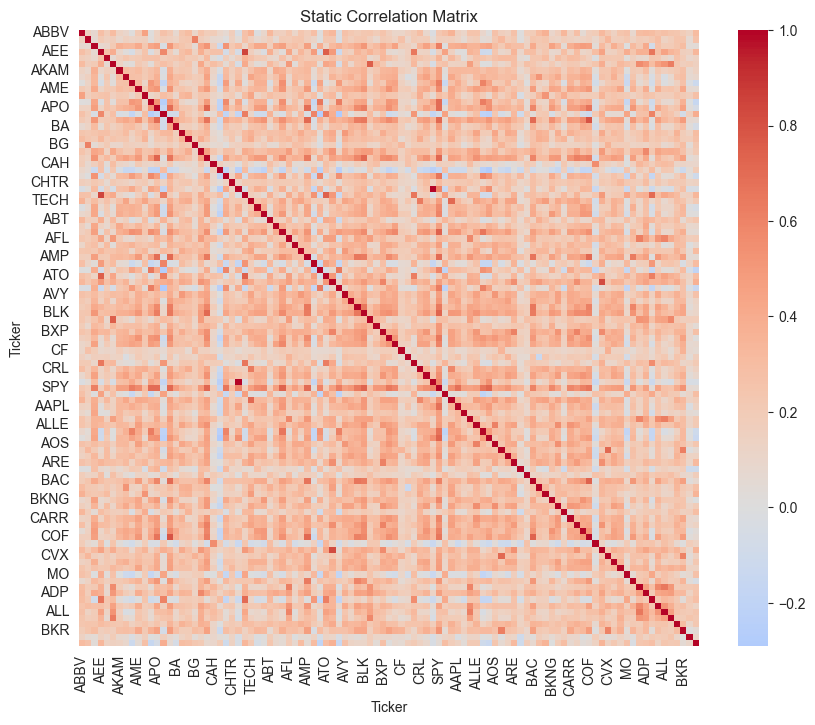

In [24]:
4# =========================================================
# 3. STATIC CORRELATION MATRIX
# =========================================================
static_corr = returns.corr()

# 只在 universe 较小时画热力图
if static_corr.shape[0] <= 101:
    plt.figure(figsize=(10, 8))
    sns.heatmap(static_corr, cmap="coolwarm", center=0)
    plt.title("Static Correlation Matrix")
    plt.show()


In [25]:
# =========================================================
# 4. K-MEANS CLUSTERING (scalable)
# =========================================================
X = static_corr.values

kmeans = MiniBatchKMeans(
    n_clusters=N_CLUSTERS,
    random_state=42,
    batch_size=256,
    n_init=10
)
kmeans.fit(X)

cluster_map = pd.DataFrame({
    "Ticker": static_corr.index,
    "Cluster": kmeans.labels_
})

print("\n--- Cluster Distribution ---")
print(cluster_map["Cluster"].value_counts().sort_index())


--- Cluster Distribution ---
Cluster
0    17
1    16
2    23
3    12
4    31
Name: count, dtype: int64


In [26]:
# =========================================================
# 5. ROLLING CORRELATION VS MARKET
# =========================================================
benchmark_returns = returns[BENCHMARK]

rolling_corr = (
    returns
    .rolling(window=ROLLING_WINDOW)
    .corr(benchmark_returns)
)

static_corr_to_bench = returns.corr()[BENCHMARK]

current_rolling_corr = rolling_corr.iloc[-1]
corr_delta = current_rolling_corr - static_corr_to_bench

In [27]:
# =========================================================
# 6. OPPORTUNITY SCORE (generalized)
# =========================================================
def calculate_opportunity_score(chart_score, news_score, rolling_delta):
    """
    Final Score:
    W1 * Chart + W2 * News + W3 * Correlation Regime
    """
    W1, W2, W3 = 0.4, 0.3, 0.3

    k_corr_score = 0
    if rolling_delta < -0.1:
        k_corr_score = 0.5
    elif rolling_delta > 0.2:
        k_corr_score = -0.5

    return W1 * chart_score + W2 * news_score + W3 * k_corr_score


# 👉 这里用 dummy scores（之后你可以接技术指标 / 新闻 Agent）
chart_scores = pd.Series(0.0, index=returns.columns)
news_scores = pd.Series(0.0, index=returns.columns)

# 示例：假设最近 20 日收益率为 chart proxy
chart_scores = returns.tail(20).mean()

opportunity_scores = pd.Series(index=returns.columns, dtype=float)

for ticker in returns.columns:
    opportunity_scores[ticker] = calculate_opportunity_score(
        chart_score=chart_scores.get(ticker, 0),
        news_score=news_scores.get(ticker, 0),
        rolling_delta=corr_delta.get(ticker, 0)
    )

In [28]:
# =========================================================
# 7. FINAL OUTPUT
# =========================================================
final_df = (
    pd.DataFrame({
        "Cluster": cluster_map.set_index("Ticker")["Cluster"],
        "ChartScore": chart_scores,
        "RollingCorrDelta": corr_delta,
        "OpportunityScore": opportunity_scores
    })
    .dropna()
    .sort_values("OpportunityScore", ascending=False)
)

print("\n--- Top Opportunities ---")
print(final_df.head(10))

print("\n--- Bottom Opportunities ---")
print(final_df.tail(10))


--- Top Opportunities ---
        Cluster  ChartScore  RollingCorrDelta  OpportunityScore
Ticker                                                         
CZR           0    0.007752         -0.569787          0.153101
BKNG          2    0.006488         -0.494503          0.152595
ACN           4    0.006181         -0.259894          0.152472
ALB           2    0.006106         -0.207181          0.152442
ABNB          2    0.005944         -0.235985          0.152378
CCL           0    0.005721         -0.170516          0.152288
AIG           4    0.005434         -0.144489          0.152174
XYZ           2    0.004991         -0.461796          0.151997
BX            0    0.004831         -0.565163          0.151932
BALL          4    0.004631         -0.420744          0.151852

--- Bottom Opportunities ---
        Cluster  ChartScore  RollingCorrDelta  OpportunityScore
Ticker                                                         
AMD           2   -0.006495          0.029140  